# **Group 13**:
Evan Garcia, Jacob Ramos, Casey Kwinn, Daniel Cook

# **Project**: Traffic Volume

Traffic is a daily dilemma that most people face in their life way too many times. The average driver in America spends 293 hrs annually behind the wheel.

Our group goal is to predict metro traffic volume based on:
Hourly weather features, 
Temperature,
Holidays,
 & Date/Time.

We will use a dataset that contains the number of instances of metro traffic during different conditions and features. We want to run and use different regression models to measure and figure out what attributes/features causes the most noticeable effect in traffic. Some techniques we plan to use are the K-Mean Clustering and Cross-Validation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import matplotlib.cm as cm
from sklearn.cluster import KMeans
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df = df.fillna(0)
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


This is our graph that has 9 columns: Holiday, Temp, Rain1Hour, Snow1Hour, CloudAll, MainWeather, WeatherDescription, DateTime, and TrafficVolume. To start our EDA, we first want to figure out how many unique values there are in each category.

In [2]:
df2 = df
df2.nunique(axis=0)

holiday                   12
temp                    5843
rain_1h                  372
snow_1h                   12
clouds_all                60
weather_main              11
weather_description       38
date_time              40575
traffic_volume          6704
dtype: int64

We are now checking the means, count, min, max, and more about this dataset and put it in scientific notation

In [3]:
df2.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


To go further in examining the data, we will focus on getting a better understanding of the variables and values.

In [4]:
df2.weather_main.unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [5]:
df2.snow_1h.unique()

array([0.  , 0.51, 0.32, 0.06, 0.05, 0.21, 0.25, 0.44, 0.13, 0.1 , 0.17,
       0.08])

In [6]:
df2.holiday.unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [7]:
df2.clouds_all.unique()

array([ 40,  75,  90,   1,  20,   0, 100,  92,  99,  81,  50,  72,  56,
        57,  93,  85,  68,  87,  91,  96,  48,  60,   8,  38,  46,  98,
        86,  16,   6,  59,  54,  89,  78,  36,  17,  58,  63,  42,  25,
        11,  13,  83,  70,  84,   3,  77,  88,  67,  97,  62,  32,   4,
         5,   2,  44,  24,  76,  64,  80,  12], dtype=int64)

In [8]:
df2.weather_description.unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

While examining the unique values, one thing we notice in weather description is that some of it is similar to each other, such as 'thunderstorm with light drizzle' and 'thunderstorm with drizzle'. This is redundant and we want to reclassify some of these descriptions.

In [9]:
def clean_weather_description(row):
    
    simplifythunderstormrain = ['thunderstorm with light rain', 'thunderstorm with rain', 'thunderstorm with heavy rain' ]
    simplifythunderstormdrizzle = ['thunderstorm with drizzle', 'thunderstorm with light drizzle']
    simplifydrizzle = ['light intensity drizzle', 'drizzle', 'heavy intensity drizzle']
    simplifyskyclear = ['sky is clear','Sky is Clear']
    simplifyheavyrain = ['heavy intensity rain', 'very heavy rain']
    simplifylightsnow = ['light shower snow', 'light snow']
    simplifyshowerrain = ['proximity shower rain', 'shower rain', 'light intensity shower rain']
    simplifysquall = ['freezing rain', 'light rain and snow', 'SQUALLS']
    
    if row.weather_description in simplifythunderstormrain:
        return 'thunderstorm with rain'   
    if row.weather_description in simplifythunderstormdrizzle:
        return 'thunderstorm with drizzle' 
    if row.weather_description in simplifydrizzle:
        return 'drizzle' 
    if row.weather_description in simplifyskyclear:
        return 'clear'
    if row.weather_description in simplifyheavyrain:
        return 'heavy rain'
    if row.weather_description in simplifylightsnow:
        return 'light snow'
    if row.weather_description in simplifyshowerrain:
        return 'shower rain'
    if row.weather_description in simplifysquall:
        return 'squall'
    return row.weather_description # Clean dataframe
def clean_df(playlist):
    df_cleaned = df2.copy()
    df_cleaned['weather_description'] = df_cleaned.apply(lambda row: clean_weather_description(row), axis=1)
    return df_cleaned# Get df with reclassfied 'condition' column
df_cleaned = clean_df(df2)
df_cleaned.weather_description.unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds', 'clear',
       'few clouds', 'light rain', 'drizzle', 'mist', 'haze', 'fog',
       'shower rain', 'moderate rain', 'heavy rain',
       'proximity thunderstorm', 'thunderstorm with rain',
       'proximity thunderstorm with rain', 'heavy snow', 'snow', 'squall',
       'shower snow', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'thunderstorm with drizzle', 'light snow', 'smoke',
       'shower drizzle', 'sleet'], dtype=object)

As shown, we reduced some of the variables that were redundant.

Going through the dataset, we realize that the columns of rain and snow 1 hour on the cluster graphs we made have very little use or info to extract from because most of the time the column is equal to 0. So we will rid of these columns.

In [10]:
df_cleaned = df_cleaned.copy().drop(['rain_1h','snow_1h'], axis=1)
df_cleaned.nunique(axis=0)

holiday                   12
temp                    5843
clouds_all                60
weather_main              11
weather_description       27
date_time              40575
traffic_volume          6704
dtype: int64

Now the next step in the EDA is to rid of some outliers, like in the temp category and others. We also wanted to split the column date_time into two seprate columns instead of one.

In [11]:
df_cleaned = df_cleaned[df_cleaned['temp'].between(250.00, 312.00)]
df_cleaned = df_cleaned[df_cleaned['traffic_volume'] > 1000]
df_cleaned = df_cleaned[df_cleaned['date_time'] > '2013-12-31 23:00:00']

column_to_move = df_cleaned.pop('traffic_volume')
df_cleaned.insert(0, 'traffic_volume', column_to_move)
df_cleaned[['date' ,'time']] = df_cleaned.date_time.str.split(expand=True)
df_cleaned = df_cleaned.drop('date_time', axis=1)

df_cleaned.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,traffic_volume,temp,clouds_all
count,28431.000000,28431.000000,28431.000000
mean,4064.615560,283.118130,49.481411
std,1489.593677,12.530442,38.711727
min,1001.000000,250.010000,0.000000
25%,2879.000000,273.850000,1.000000
50%,4343.000000,285.440000,64.000000
75%,5192.000000,293.520000,90.000000
max,7280.000000,310.070000,100.000000


Now we will see the brand new cleaned dataset that we will work with on the main part.

In [12]:
df_cleaned

,traffic_volume,holiday,temp,clouds_all,weather_main,weather_description,date,time
11132,1395,New Years Day,250.14,90,Clouds,overcast clouds,2014-01-01,00:00:00
11133,1292,None,250.39,75,Clouds,broken clouds,2014-01-01,01:00:00
11141,1258,None,251.80,90,Clouds,overcast clouds,2014-01-01,09:00:00
11142,2360,None,253.88,90,Clouds,overcast clouds,2014-01-01,11:00:00
11143,2574,None,255.36,64,Clouds,broken clouds,2014-01-01,12:00:00
...,...,...,...,...,...,...,...,...
48198,3947,None,284.20,75,Rain,light rain,2018-09-30,18:00:00
48199,3543,None,283.45,75,Clouds,broken clouds,2018-09-30,19:00:00
48200,2781,None,282.76,90,Clouds,overcast clouds,2018-09-30,20:00:00
48201,2159,None,282.73,90,Thunderstorm,proximity thunderstorm,2018-09-30,21:00:00


Now that the dataset has been cleaned we can perform some basic exploratory data analysis to see what we're dealing with. We can start with some bar graphs showing the correleation between traffic volume and the other variables in the dataset.

To start, it seems like holidays have, on average, significantly lower traffic volume than non-holidays. Although this makes sense, the dataset only contains several entries of holidays, so the sample size isn't very large.

<AxesSubplot:xlabel='holiday'>

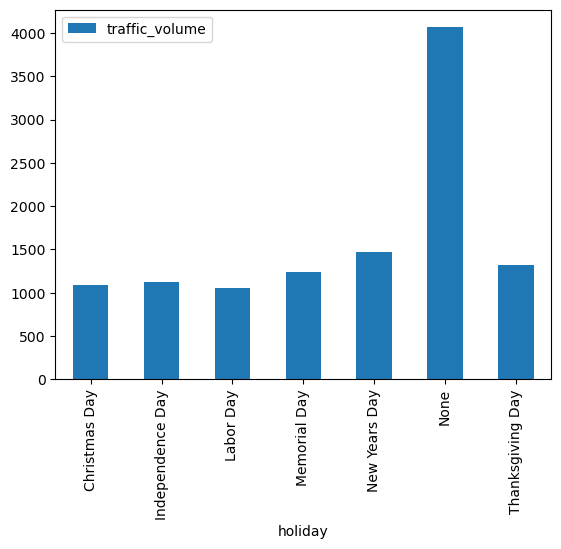

In [13]:
df_pt = df_cleaned.pivot_table(values='traffic_volume',index='holiday',aggfunc=np.mean)
df_pt.plot(kind='bar')

Next, it appears that temperature and cloud coverage have little affect on traffic volume, although the does seem to be a small correlation between lower temperature and lower traffic volume on average.

<AxesSubplot:xlabel='temp_range'>

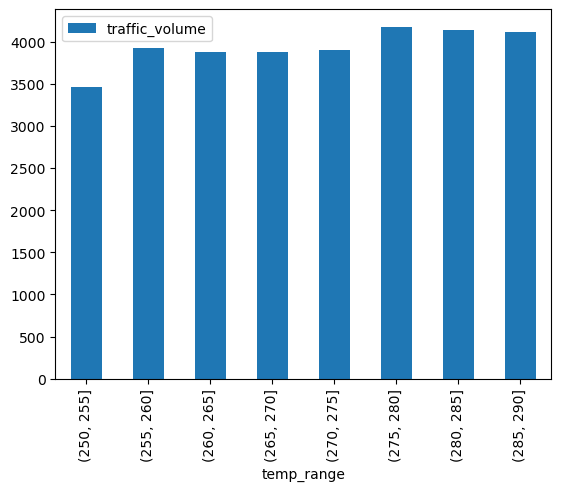

In [14]:
df_pt2 = df_cleaned
df_pt2['temp_range'] = pd.cut(x=df_pt2['temp'], bins=[250,255,260,265,270,275,280,285,290])
df_pt2.pivot_table(values='traffic_volume',index='temp_range',aggfunc=np.mean).plot(kind='bar')

<AxesSubplot:xlabel='clouds_range'>

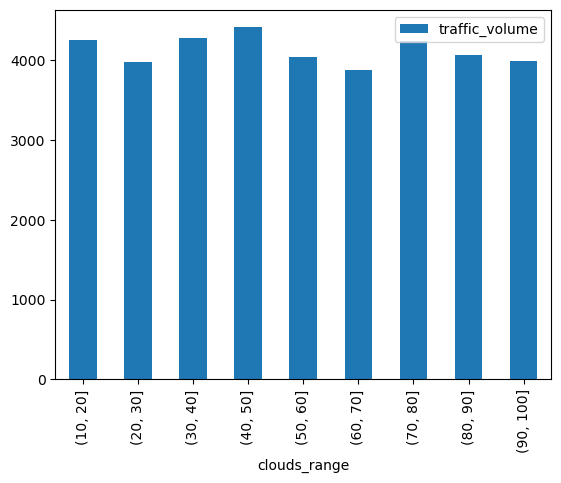

In [15]:
df_pt3 = df_cleaned
df_pt3['clouds_range'] = pd.cut(x=df_pt3['clouds_all'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
#df_pt3['clouds_range'].value_counts()
df_pt3.pivot_table(values='traffic_volume',index='clouds_range',aggfunc=np.mean).plot(kind='bar')

<AxesSubplot:xlabel='weather_main'>

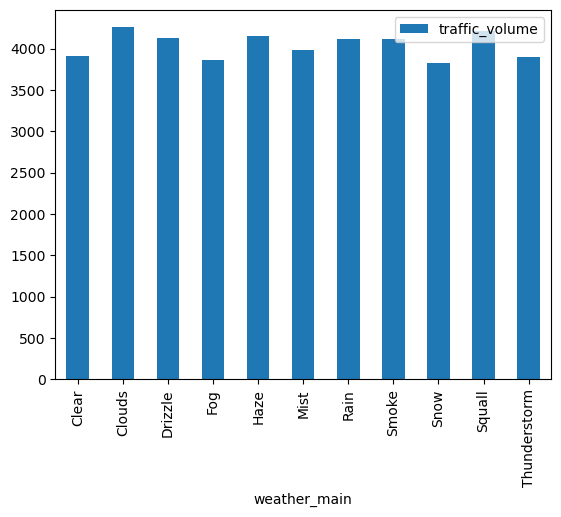

In [16]:
df_pt4 = df_cleaned.pivot_table(values='traffic_volume',index='weather_main',aggfunc=np.mean)
df_pt4.plot(kind='bar')

As for weather, there tends to be lower traffic volume during light and heavy snowfall, whereas traffic volume seems mostly unaffected by other weather patterns.

<AxesSubplot:xlabel='weather_description'>

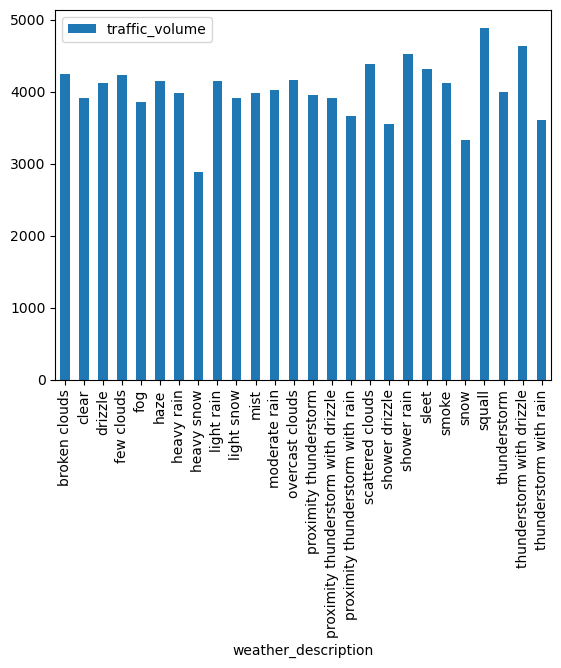

In [17]:
df_pt5 = df_cleaned.pivot_table(values='traffic_volume',index='weather_description',aggfunc=np.mean)
df_pt5.plot(kind='bar')

Finally, time of day seems to have a very obvious impact on traffic volume. Late hours of the night have very reduced traffic volume, where as working hours of the day have much higher volume, with peaks occuring at the start and end hours of the day.

<AxesSubplot:xlabel='time'>

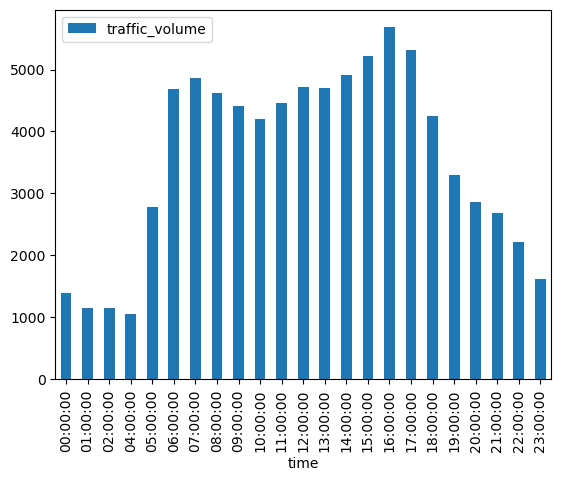

In [18]:
df_pt6 = df_cleaned.pivot_table(values='traffic_volume',index='time',aggfunc=np.mean)
df_pt6.plot(kind='bar')

## **Main Part**

For our project, we are going to use K-Mean Clustering on our dataset to find clusters that show the attributes that have the most influence on metropolitan traffic. (Just testing and messing with data) **Ignore for now, still cleaning dataset**

<AxesSubplot:xlabel='temp', ylabel='time'>

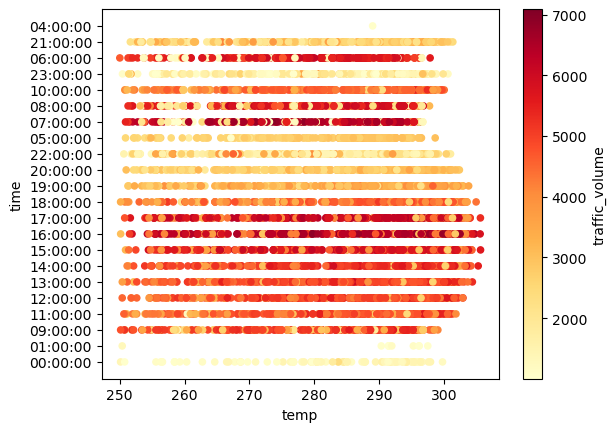

In [19]:
test_df = df_cleaned
test_train = test_df.loc[:'2016-12-31'].copy
test_test = test_df.loc[:'2017-01-01'].copy
test_train().plot.scatter(x="temp", y="time", c="traffic_volume", cmap=cm.YlOrRd)

In [20]:
x = df[['temp', 'traffic_volume']].copy()
x

,temp,traffic_volume
0,288.28,5545
1,289.36,4516
2,289.58,4767
3,290.13,5026
4,291.14,4918
...,...,...
48199,283.45,3543
48200,282.76,2781
48201,282.73,2159
48202,282.09,1450


In [21]:
kmean = KMeans(3)
kmean.fit(x)
identified_clusters = kmean.fit_predict(x)
identified_clusters

array([1, 1, 1, ..., 2, 0, 0])

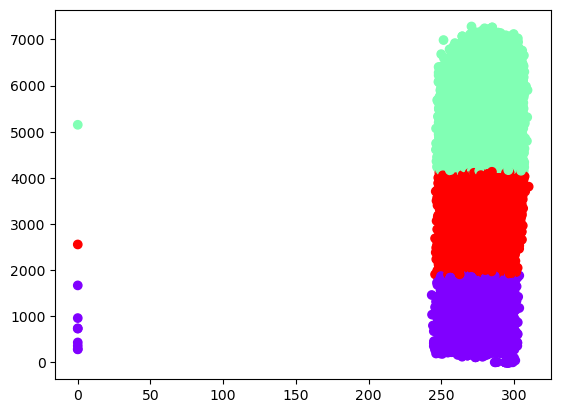

In [22]:
data_with_clusters = df.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['temp'],data_with_clusters['traffic_volume'],c=data_with_clusters['Clusters'],cmap='rainbow')

This is just to see if a elbow test can work

Text(0, 0.5, 'WCSS')

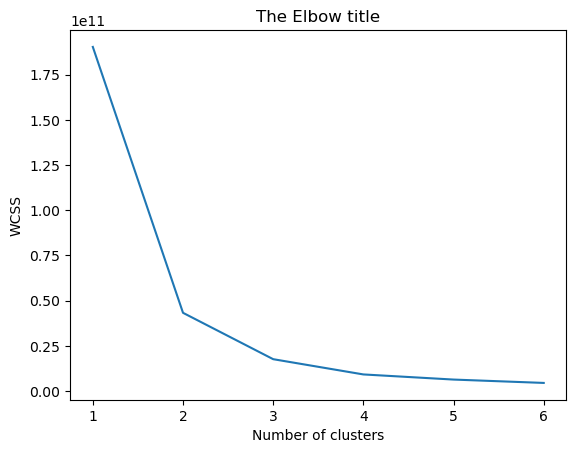

In [23]:
wcss = []
for i in range(1,7):
    kmean = KMeans(i)
    kmean.fit(x)
    wcss_iter = kmean.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

did temp and traffic, now clouds and traffic

In [24]:
y = df[['clouds_all', 'traffic_volume']].copy()
y

,clouds_all,traffic_volume
0,40,5545
1,75,4516
2,90,4767
3,90,5026
4,75,4918
...,...,...
48199,75,3543
48200,90,2781
48201,90,2159
48202,90,1450


In [25]:
kmean2 = KMeans(3)
kmean2.fit(y)
identified_clusters2 = kmean2.fit_predict(y)
identified_clusters2

array([1, 1, 1, ..., 0, 2, 2])

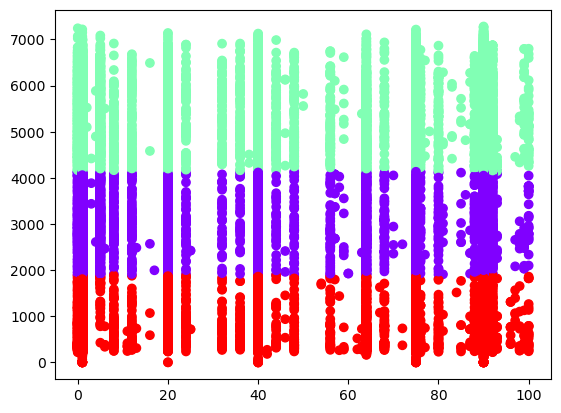

In [26]:
data_with_clusters2 = df.copy()
data_with_clusters2['Clusters'] = identified_clusters2 
plt.scatter(data_with_clusters2['clouds_all'],data_with_clusters2['traffic_volume'],c=data_with_clusters2['Clusters'],cmap='rainbow')

       traffic_level  traffic_volume
0                  2            5545
1                  2            4516
2                  2            4767
3                  2            5026
4                  2            4918
...              ...             ...
48199              1            3543
48200              1            2781
48201              1            2159
48202              0            1450
48203              0             954

[48204 rows x 2 columns]


C:\Users\garth\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


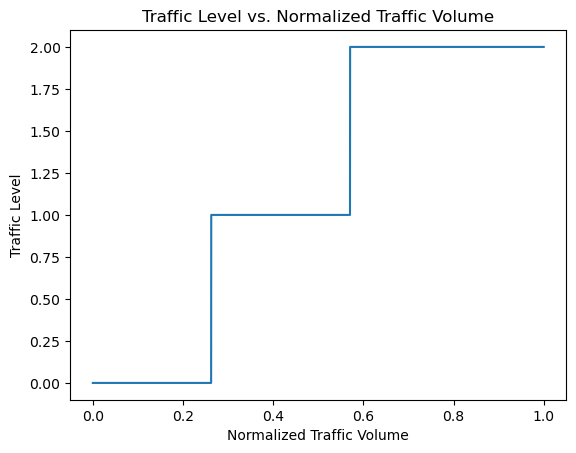

In [27]:
#df['traffic_volume'] = df['traffic_volume'].astype(float)
#kmeans = KMeans(n_clusters=3, random_state=0).fit(df['traffic_volume'])

# add the cluster labels to the dataframe
#df['traffic_level'] = kmeans.labels_
from sklearn.cluster import KMeans

# reshape the data to have two dimensions
data = np.array(df['traffic_volume']).reshape(-1, 1)
sorted_data = np.sort(df['traffic_volume'])
initial_centroids = np.array([
    [sorted_data[int(0 * len(sorted_data) / 100)]],
    [sorted_data[int(50 * len(sorted_data) / 100)]],
    [sorted_data[int(100 * (len(sorted_data)-1) / 100)]]
])

# fit KMeans model with specified initial centroids
kmeans = KMeans(n_clusters=3, init=initial_centroids).fit(data)

# add the cluster labels to the dataframe
df['traffic_level'] = kmeans.labels_
print(df[['traffic_level', 'traffic_volume']])
# sort the DataFrame by 'traffic_volume' column
df = df.sort_values('traffic_volume')

# normalize the 'traffic_volume' column between 0 and 1
df['normalized_traffic_volume'] = (df['traffic_volume'] - df['traffic_volume'].min()) / (df['traffic_volume'].max() - df['traffic_volume'].min())

# plot the line chart
plt.plot(df['normalized_traffic_volume'], df['traffic_level'])
plt.xlabel('Normalized Traffic Volume')
plt.ylabel('Traffic Level')
plt.title('Traffic Level vs. Normalized Traffic Volume')
plt.show()

In [28]:
rain = df[['rain_1h', 'traffic_volume']].copy()
rain

,rain_1h,traffic_volume
25186,0.0,0
25191,0.0,0
24821,0.0,1
16849,0.0,1
26438,0.0,1
...,...,...
5619,0.0,7217
22671,0.0,7241
22640,0.0,7260
22641,0.0,7260


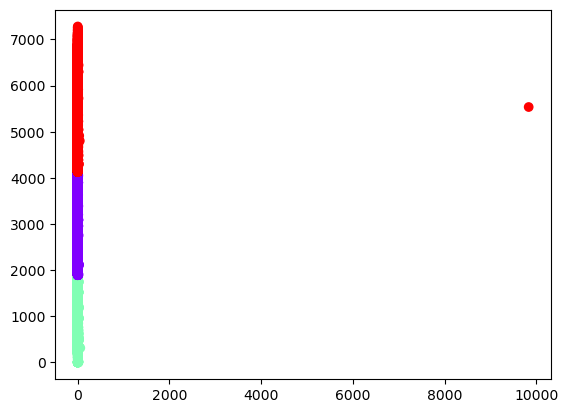

In [29]:
kmean3 = KMeans(3)
kmean3.fit(rain)
identified_clusters3 = kmean3.fit_predict(rain)
data_with_clusters3 = df.copy()
data_with_clusters3['Clusters'] = identified_clusters3
plt.scatter(data_with_clusters3['rain_1h'],data_with_clusters3['traffic_volume'],c=data_with_clusters3['Clusters'],cmap='rainbow')

In [30]:
snow = df[['snow_1h', 'traffic_volume']].copy()
snow

,snow_1h,traffic_volume
25186,0.0,0
25191,0.0,0
24821,0.0,1
16849,0.0,1
26438,0.0,1
...,...,...
5619,0.0,7217
22671,0.0,7241
22640,0.0,7260
22641,0.0,7260


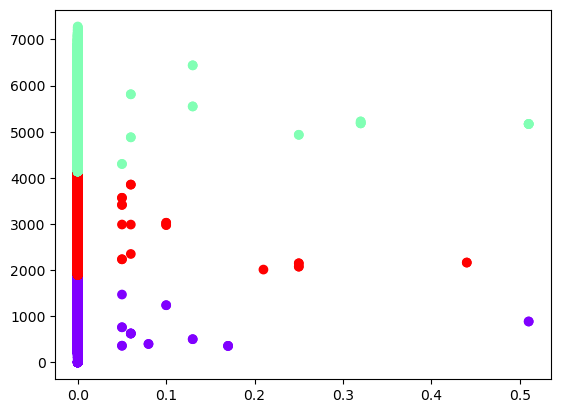

In [31]:
kmean4 = KMeans(3)
kmean4.fit(snow)
identified_clusters4 = kmean4.fit_predict(rain)
data_with_clusters4 = df.copy()
data_with_clusters4['Clusters'] = identified_clusters4
plt.scatter(data_with_clusters4['snow_1h'],data_with_clusters4['traffic_volume'],c=data_with_clusters4['Clusters'],cmap='rainbow')

In [32]:
time = df[['date_time', 'traffic_volume']].copy()
time

,date_time,traffic_volume
25186,2016-07-23 18:00:00,0
25191,2016-07-23 23:00:00,0
24821,2016-07-09 23:00:00,1
16849,2015-07-25 08:00:00,1
26438,2016-09-07 23:00:00,1
...,...,...
5619,2013-04-30 07:00:00,7217
22671,2016-04-22 07:00:00,7241
22640,2016-04-21 07:00:00,7260
22641,2016-04-21 07:00:00,7260
